# Topic Modelling with Politicians' speech

## Data


The data consists of video transcriptions from Matteo Salvini's YouTube channel. The audio of the videos was transcribed using OpenAI's [Whisper](https://github.com/openai/whisper) Large Model. The code used to download and transcribe the videos can be found in `demo.ipynb` in this file's directory. The transcription was performed using a GPU rented on [vast.ai]. I decided for this solution after noticing the poor quality of transcription when performed using smaller Whisper models. This decision seems to also be supported by the quality results reported in the appendix of the [original paper](https://cdn.openai.com/papers/whisper.pdf), where the tiny model's WER, in some corpus, is more than double that of the large model for Italian.

In [37]:
import pandas as pd

In [38]:
df = pd.read_csv('../data/politopic_salvini_ytchannel_whisper_large.tsv', sep='\t')
df.head()

Title  \
0  QUESTION TIME MINISTRO SALVINI (SENATO, 01.12....   
1  QUESTION TIME MINISTRO SALVINI (SENATO, 01.12....   
2  QUESTION TIME MINISTRO SALVINI (SENATO, 01.12....   
3  QUESTION TIME MINISTRO SALVINI (SENATO, 01.12....   
4  QUESTION TIME MINISTRO SALVINI (SENATO, 01.12....   

                                                Text  
0   L'ordine del giorno rega lo svolgimento di in...  
1  Invito come sempre gli oratori al rispetto dei...  
2  Il senatore De Poli è il primo dei senatori ad...  
3               Lei ha tre minuti, senatore De Poli.  
4                                             Prego.

Only videos that Whisper identified as being in Italian were considered.

In [39]:
len(df.groupby('Title').count())

46

### Preprocessing - Lemmatization & Normalization

Let's use a very simple method of Lemmatization and Normalization.

In [40]:
import re
import stanza

nlp = stanza.Pipeline('it', processors='tokenize,mwt,pos,lemma')

2022-12-20 12:47:38 INFO: Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES
2022-12-20 12:47:39 INFO: Loading these models for language: it (Italian):
| Processor | Package  |
------------------------
| tokenize  | combined |
| mwt       | combined |
| pos       | combined |
| lemma     | combined |

2022-12-20 12:47:39 INFO: Use device: cpu
2022-12-20 12:47:39 INFO: Loading: tokenize
2022-12-20 12:47:39 INFO: Loading: mwt
2022-12-20 12:47:39 INFO: Loading: pos
2022-12-20 12:47:39 INFO: Loading: lemma
2022-12-20 12:47:39 INFO: Done loading processors!


In [41]:
def lemmatize(text: str):
    doc = nlp(text)
    lemmas = []

    for sent in doc.sentences:
        for word in sent.words:
            if word.upos != "PUNCT":
                lemmas.append(word.lemma)
    return " ".join(lemmas)

In [42]:
def normalize(text: str):
    text = re.sub("[0-9]+", "NUM", text)
    text = text.lower()
    return text

In [44]:
df["Lemmas"] = df.Text.apply(lambda text: lemmatize(normalize(text)))
df.head()

Title  \
0  QUESTION TIME MINISTRO SALVINI (SENATO, 01.12....   
1  QUESTION TIME MINISTRO SALVINI (SENATO, 01.12....   
2  QUESTION TIME MINISTRO SALVINI (SENATO, 01.12....   
3  QUESTION TIME MINISTRO SALVINI (SENATO, 01.12....   
4  QUESTION TIME MINISTRO SALVINI (SENATO, 01.12....   

                                                Text  \
0   L'ordine del giorno rega lo svolgimento di in...   
1  Invito come sempre gli oratori al rispetto dei...   
2  Il senatore De Poli è il primo dei senatori ad...   
3               Lei ha tre minuti, senatore De Poli.   
4                                             Prego.   

                                              Lemmas  
0  il ordine di il giorno regare il svolgimento d...  
1  invitare come sempre il oratore a il rispetto ...  
2  il senatore de polo essere il primo di il sena...  
3              lei avere tre minuto senatore de polo  
4                                            pregare

In [45]:
df.to_csv('../data/politopic_salvini_ytchannel_whisper_large+lemmas.tsv', sep='\t', index=False)

## Topic Modelling

### Latent Dirichlet Allocation (LDA)

LDA base assumptions:
 * a topic is a probabilistic distribution over words
 * a document is a probabilistic distribution over latent topics

In [46]:
from nltk.corpus import stopwords
import nltk

nltk.download('stopwords')
it_stopwords = stopwords.words('italian')
it_stopwords[:5]

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/andrea.grillandi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


['ad', 'al', 'allo', 'ai', 'agli']

In [47]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

In [48]:
df = pd.read_csv('../data/politopic_salvini_ytchannel_whisper_large+lemmas.tsv', sep='\t')
df.head()

Title  \
0  QUESTION TIME MINISTRO SALVINI (SENATO, 01.12....   
1  QUESTION TIME MINISTRO SALVINI (SENATO, 01.12....   
2  QUESTION TIME MINISTRO SALVINI (SENATO, 01.12....   
3  QUESTION TIME MINISTRO SALVINI (SENATO, 01.12....   
4  QUESTION TIME MINISTRO SALVINI (SENATO, 01.12....   

                                                Text  \
0   L'ordine del giorno rega lo svolgimento di in...   
1  Invito come sempre gli oratori al rispetto dei...   
2  Il senatore De Poli è il primo dei senatori ad...   
3               Lei ha tre minuti, senatore De Poli.   
4                                             Prego.   

                                              Lemmas  
0  il ordine di il giorno regare il svolgimento d...  
1  invitare come sempre il oratore a il rispetto ...  
2  il senatore de polo essere il primo di il sena...  
3              lei avere tre minuto senatore de polo  
4                                            pregare

In [49]:
cv = CountVectorizer(
    max_df=0.4,
    min_df=2,
    max_features=1000,
    stop_words=it_stopwords
)

lda = LatentDirichletAllocation(
    n_components=10,
    max_iter=5,
    learning_method="online",
    learning_offset=50.0,
    random_state=0,
)

In [50]:
count = cv.fit_transform(df.Lemmas)
lda.fit(count)

LatentDirichletAllocation(learning_method='online', learning_offset=50.0,
                          max_iter=5, random_state=0)

In [76]:
import matplotlib.pyplot as plt

In [82]:
# from: https://scikit-learn.org/stable/auto_examples/applications/plot_topics_extraction_with_nmf_lda.html#sphx-glr-auto-examples-applications-plot-topics-extraction-with-nmf-lda-py
def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(2, 5, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 30})
        ax.invert_yaxis()
        ax.tick_params(axis="both", which="major", labelsize=20)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

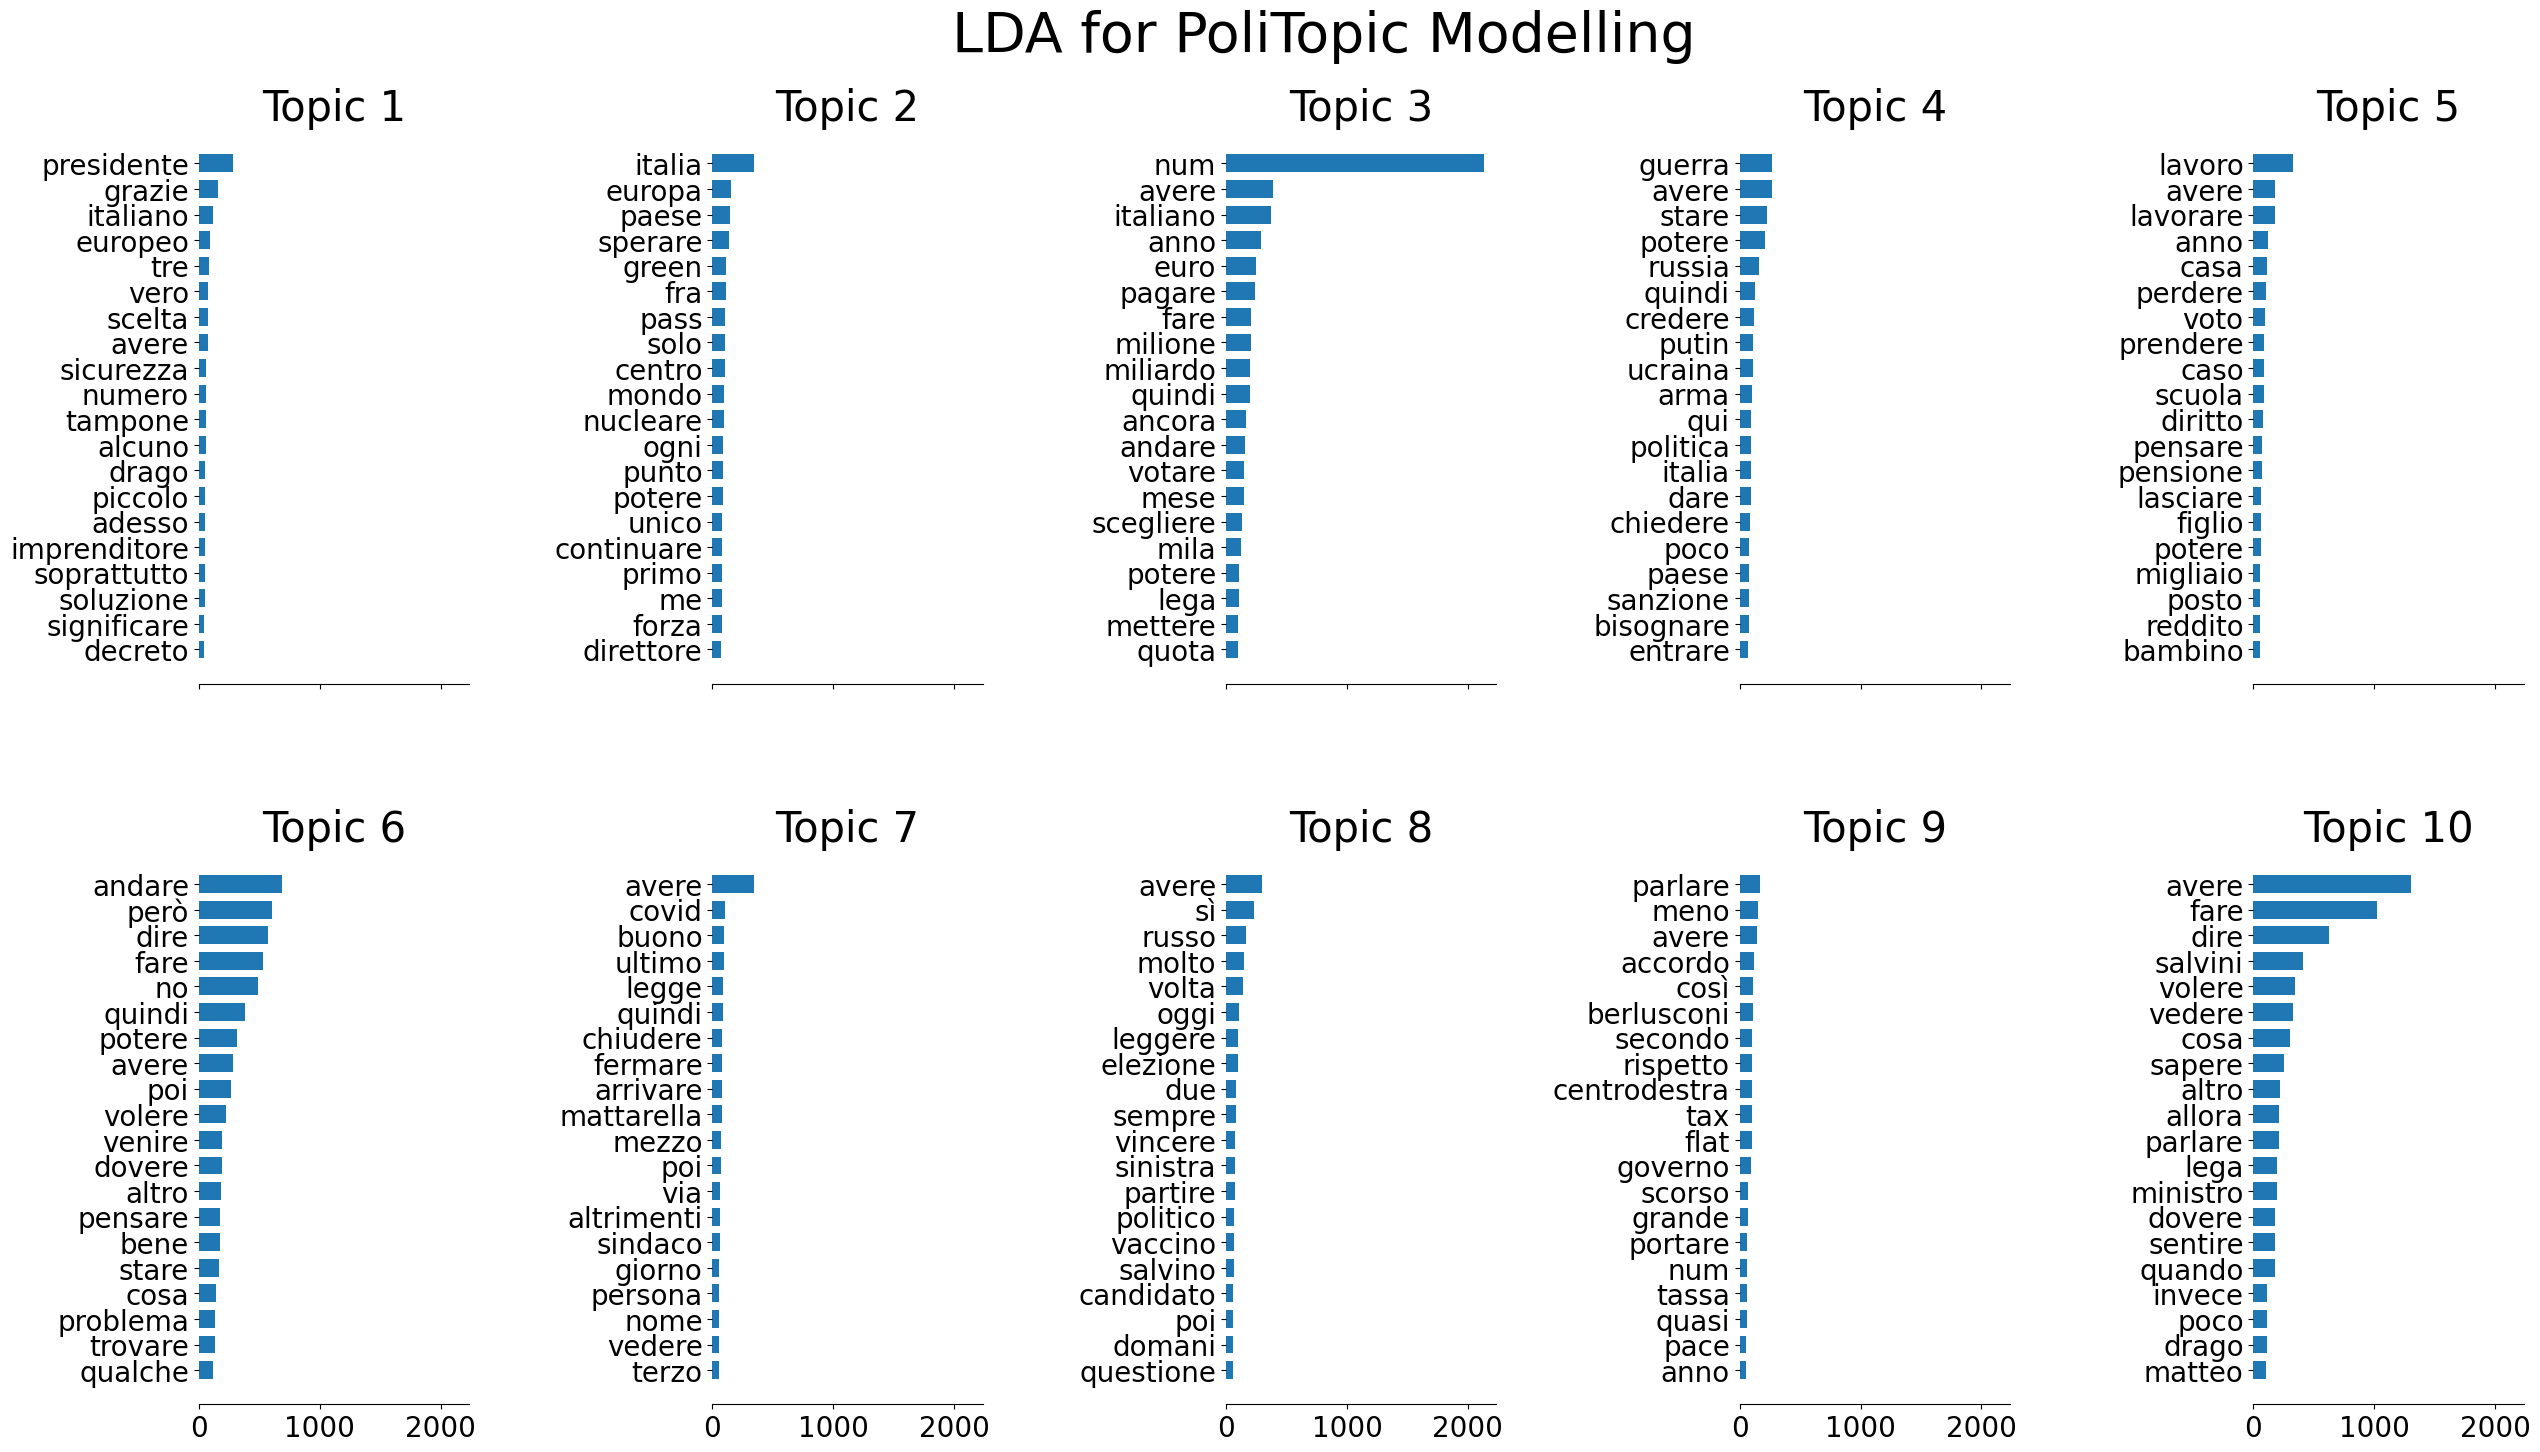

In [83]:
model = lda
feature_names = cv.get_feature_names_out()
n_top_words = 20
title = "LDA for PoliTopic Modelling"

plot_top_words(lda, feature_names, n_top_words, title)

### Non-Negative Matrix Factorization (NMF)

From sklearn: Find two non-negative matrices, i.e. matrices with all non-negative elements, (W, H) whose product approximates the non-negative matrix X. This factorization can be used for example for dimensionality reduction, source separation or topic extraction.

In [84]:
from sklearn.decomposition import NMF, MiniBatchNMF
from sklearn.feature_extraction.text import TfidfVectorizer

In [85]:
tfidf = TfidfVectorizer(
    max_df=0.95, min_df=2, max_features=1000, stop_words=it_stopwords
)

tfidf_count = tfidf.fit_transform(df.Lemmas)

In [89]:
nmf = NMF(
    n_components=10,
    random_state=1,
    init="nndsvda",
    beta_loss="frobenius",
    alpha_W=0.00005,
    alpha_H=0.00005,
    l1_ratio=1,
).fit(tfidf_count)

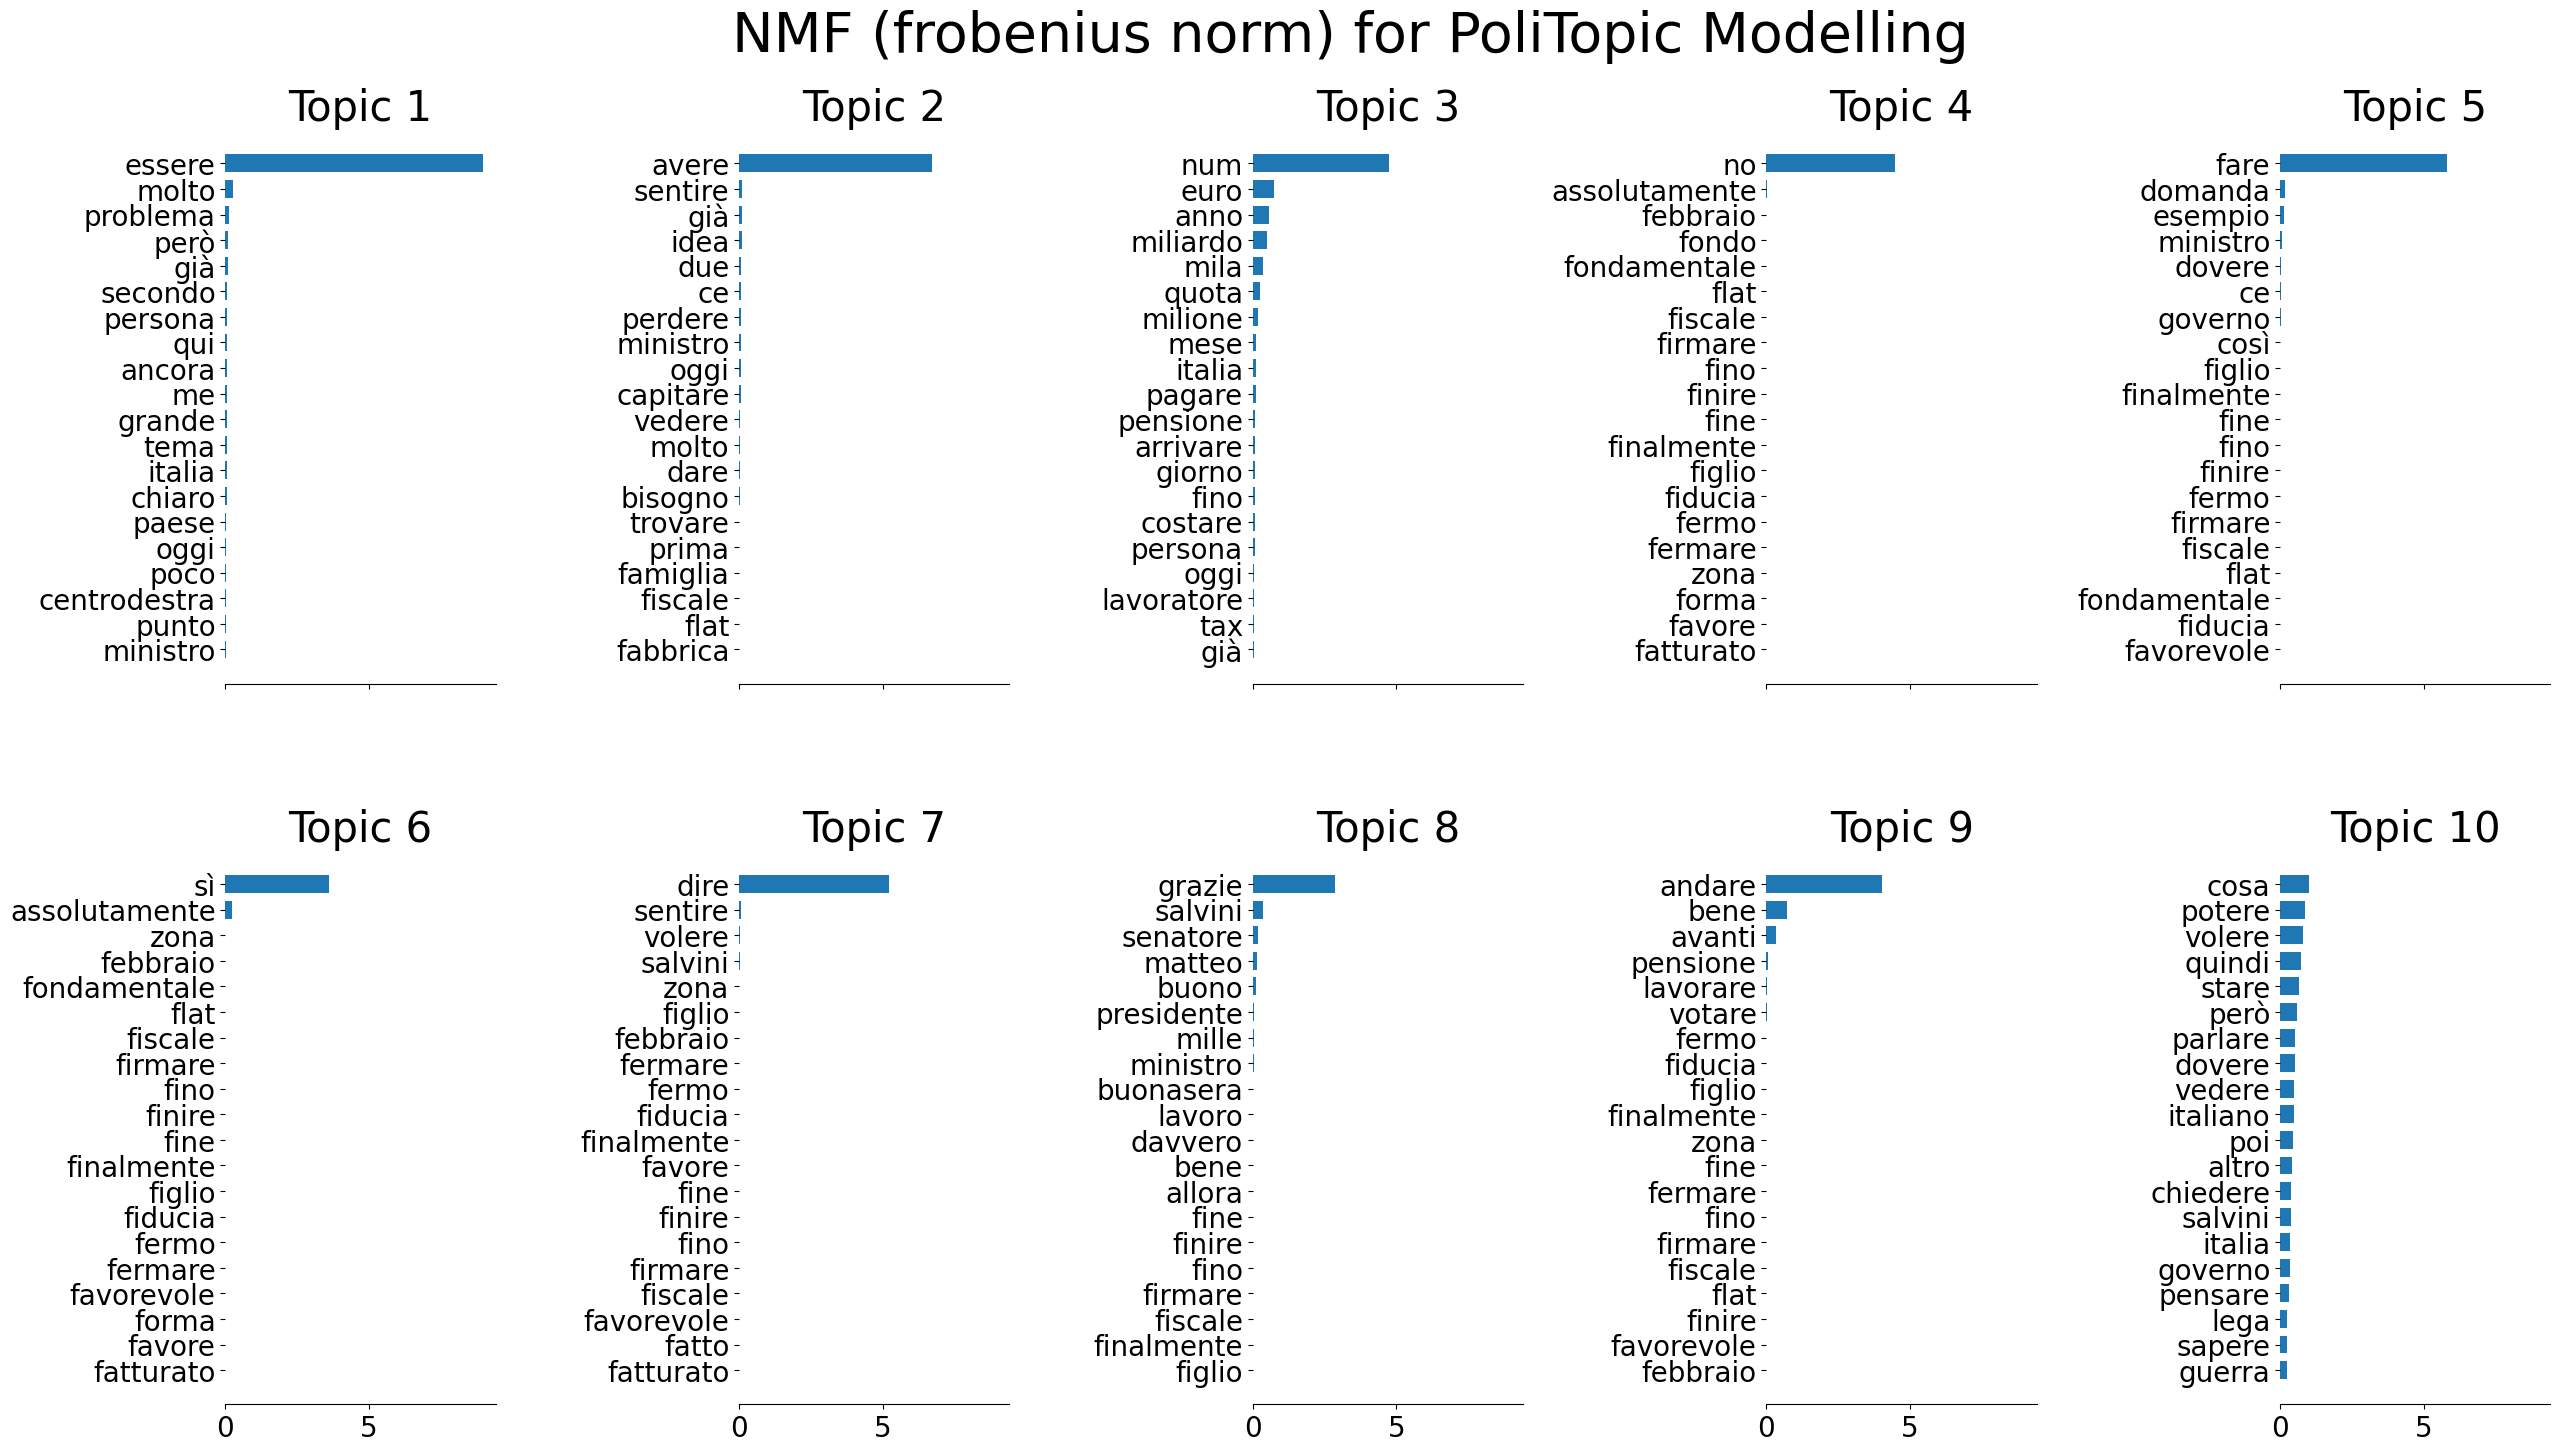

In [91]:
model = nmf
feature_names = tfidf.get_feature_names_out()
n_top_words = 20
title = "NMF (frobenius norm) for PoliTopic Modelling"

plot_top_words(model, feature_names, n_top_words, title)

In [94]:
nmf = NMF(
    n_components=10,
    random_state=1,
    init="nndsvda",
    beta_loss="kullback-leibler",
    solver="mu",
    max_iter=1000,
    alpha_W=0.00005,
    alpha_H=0.00005,
    l1_ratio=0.5,
).fit(tfidf_count)

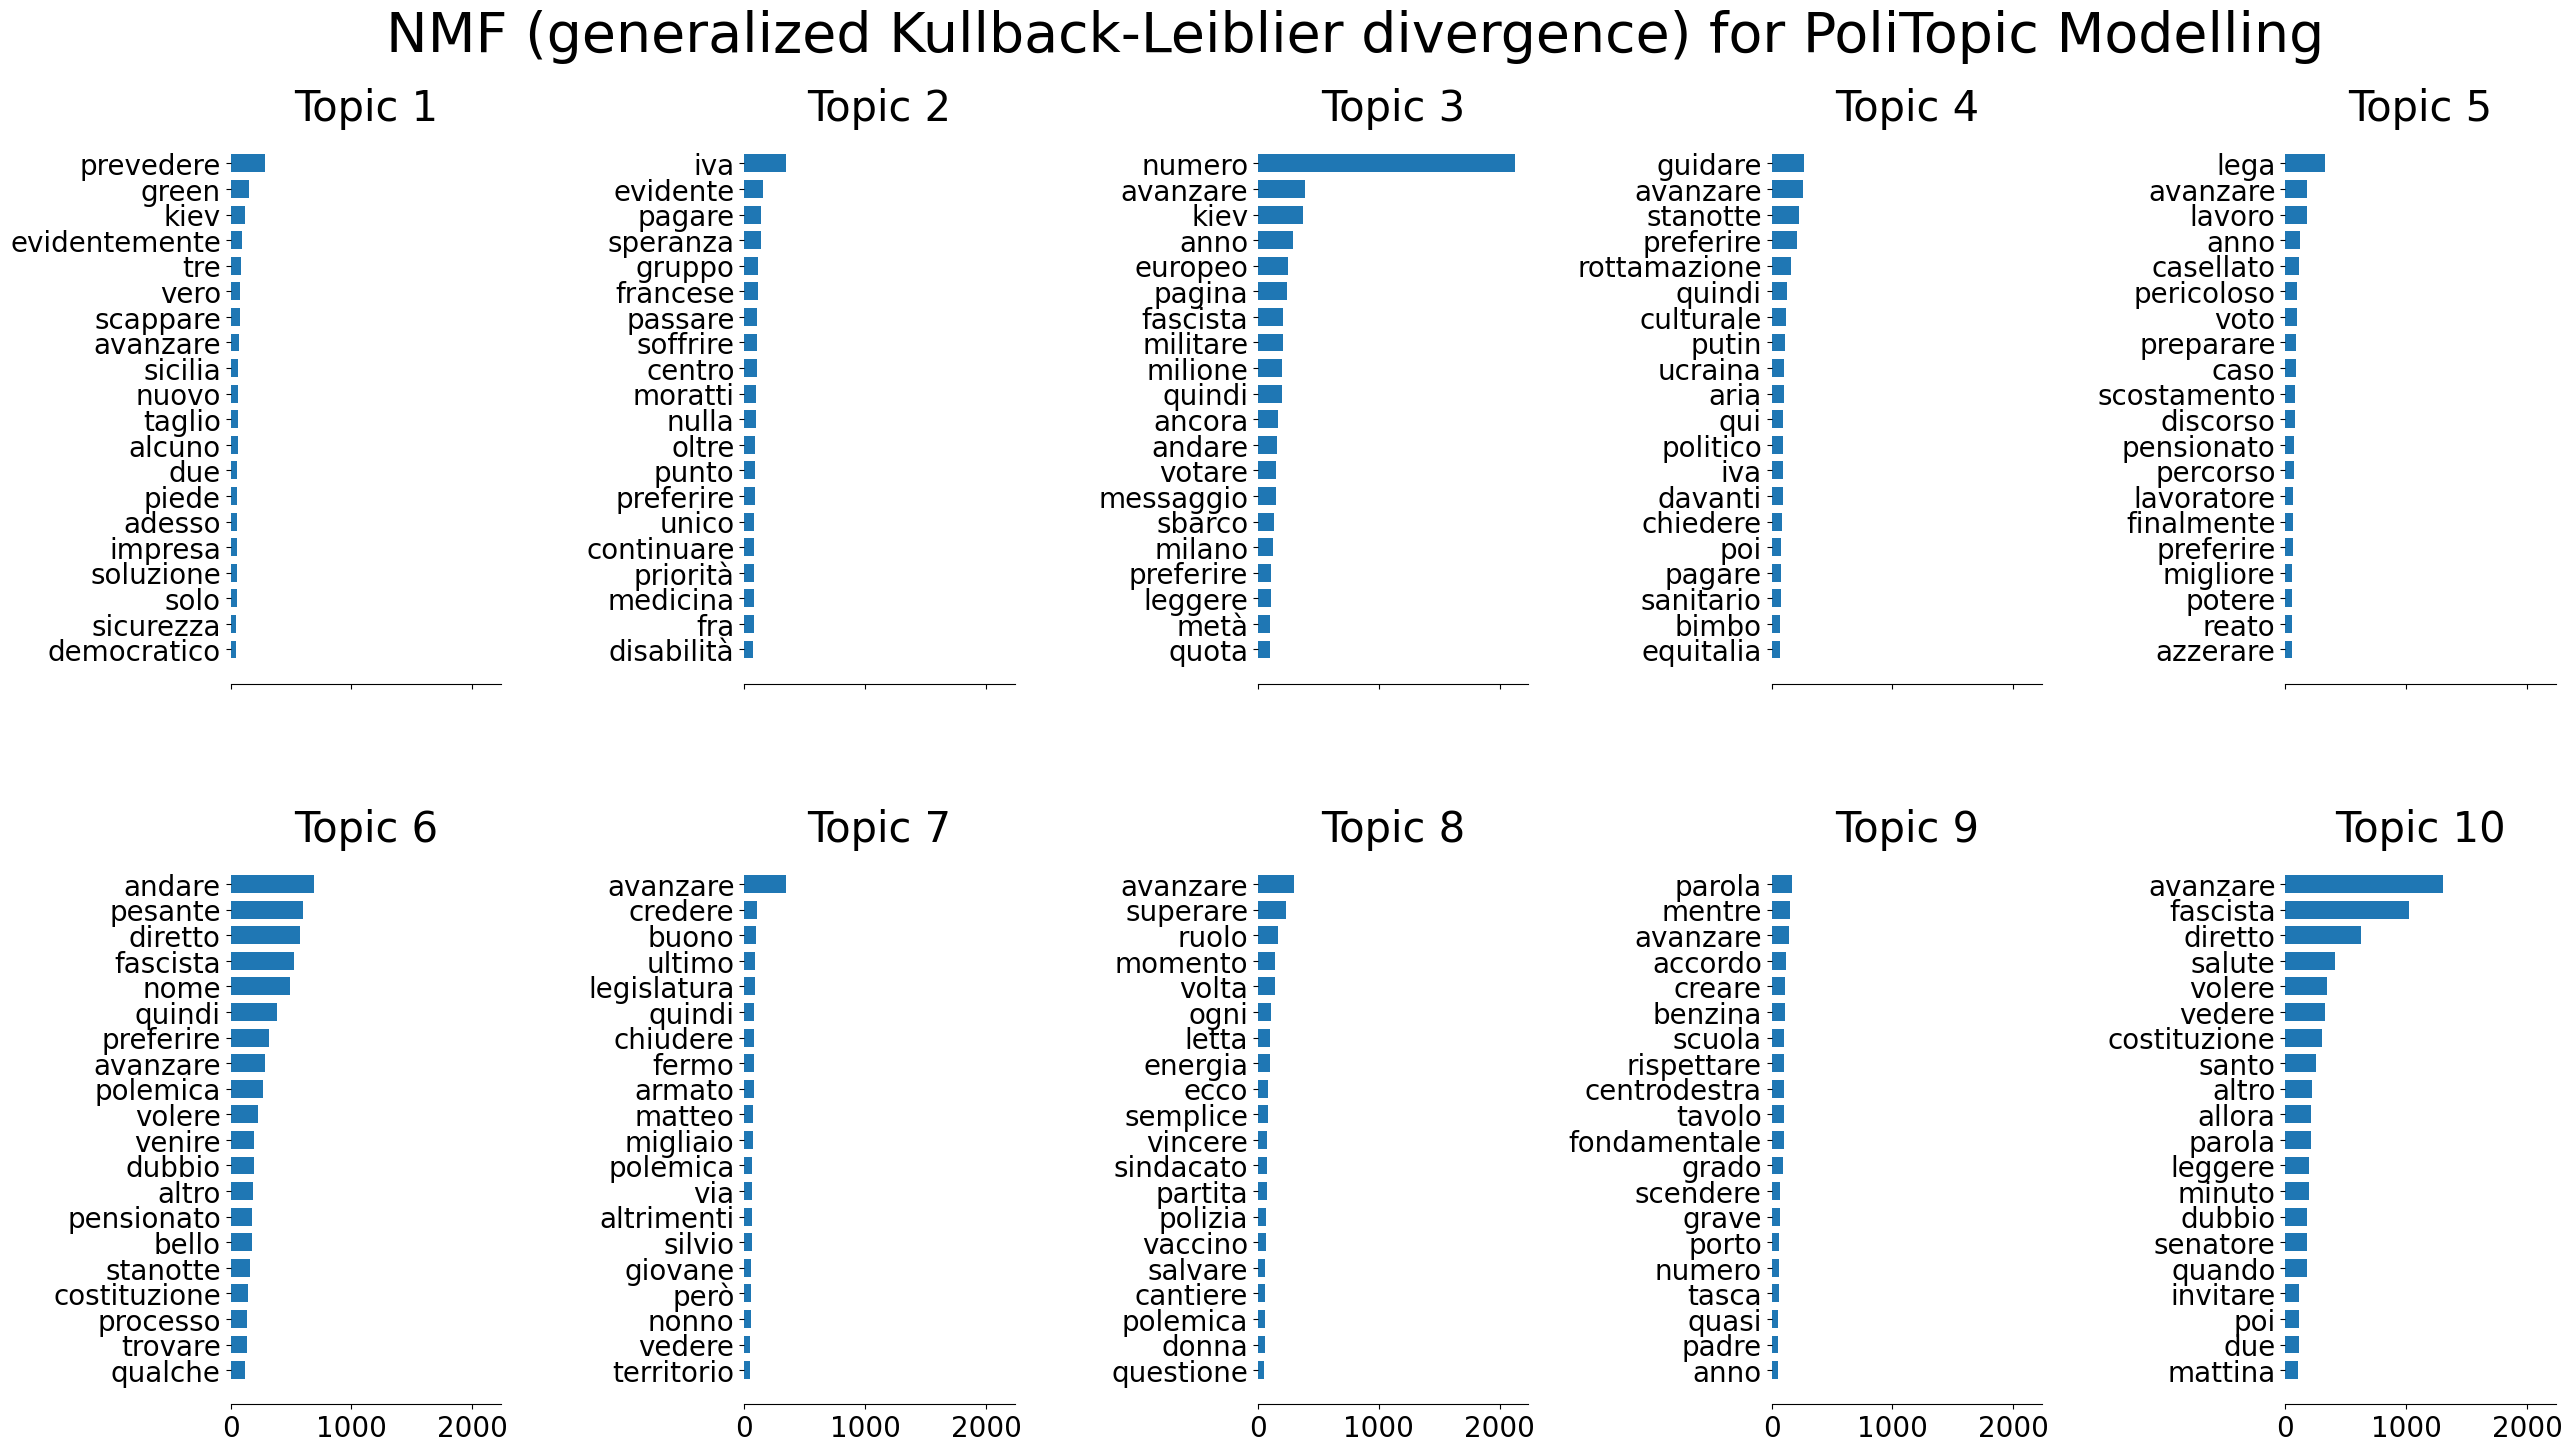

In [95]:
model = nmf
feature_names = tfidf.get_feature_names_out()
n_top_words = 20
title = "NMF (generalized Kullback-Leiblier divergence) for PoliTopic Modelling"

plot_top_words(lda, feature_names, n_top_words, title)

### BERTopic

In [99]:
from sentence_transformers import SentenceTransformer
from bertopic import BERTopic
from umap import UMAP
from hdbscan import HDBSCAN
from sklearn.feature_extraction.text import CountVectorizer

In [101]:
# Create embeddings from the documents
sentence_model = SentenceTransformer("paraphrase-multilingual-mpnet-base-v2")
embeddings = sentence_model.encode(df.Text)

In [102]:
# Define sub-models
vectorizer = CountVectorizer(stop_words=it_stopwords)
umap_model = UMAP(n_neighbors=15, n_components=5, min_dist=0.0, metric='cosine', random_state=42)
hdbscan_model = HDBSCAN(min_cluster_size=20, min_samples=2, metric='euclidean', cluster_selection_method='eom')

# Train our topic model with BERTopic
topic_model = BERTopic(
    embedding_model=sentence_model,
    umap_model=umap_model,
    hdbscan_model=hdbscan_model,
    vectorizer_model=vectorizer
).fit(df.Text, embeddings)

In [108]:
pd.set_option('display.max_rows', None)
topic_model.get_topic_info()

Topic  Count                                          Name  \
0      -1   2536                         -1_quindi_però_poi_no   
1       0    517                  0_russia_ucraina_putin_russi   
2       1    162               1_salvini_senatore_allora_prego   
3       2    155           2_italiani_lega_italia_centrodestra   
4       3    146                     3_molto_bisogna_cose_modo   
5       4    143                 4_italia_roma_milano_italiani   
6       5    131                5_europa_germania_nave_tedesca   
7       6    121                     6_vediamo_vedere_poco_tg1   
8       7    116         7_vaccino_vaccinati_vaccinato_vaccini   
9       8    115     8_immigrazione_migranti_decreti_sicurezza   
10      9    114                   9_guerra_armi_cessato_forze   
11     10    106        10_draghi_presidente_quirinale_governo   
12     11    105        11_elezioni_elettorale_votare_campagna   
13     12     92                 12_gas_energia_benzina_prezzo   
14     13     90              13_ponte_sicilia_stretto_regione   
15     14     85                       14_pensione_anni_41_età   
16     15     83        15_mario_direttore_casellati_toninelli   
17     16     80               16_ministro_interno_signor_fare   
18     17     78                17_coco_battida_cartello_assai   
19     18     77             18_miliardi_italiani_debito_tasse   
20     19     77              19_bolletta_soldi_bilancio_tassi   
21     20     73  20_centrodestra_destra_centro_centrosinistra   
22     21     72               21_caduta_sente_finisce_difetto   
23     22     70                        22_ore_ora_giorni_mesi   
24     23     70           23_alza_esatto_esattamente_sapevamo   
25     24     68            24_miliardi_miliardo_30_preferisco   
26     25     66           25_nucleare_nucleari_pulito_energia   
27     26     66                26_italiani_italia_pace_guerra   
28     27     64            27_matteo_grazie_buonasera_salvini   
29     28     54          28_lavoro_lavorare_camionisti_magari   
30     29     53             29_niente_zero_impossibile_vedete   
31     30     53                30_leggere_perdo_nessuno_vinco   
32     31     53         31_berlusconi_silvio_pianista_mariani   
33     32     53                     32_bene_va_sembra_normale   
34     33     50                 33_droga_donne_diritto_droghe   
35     34     48             34_milioni_italiani_italia_minimo   
36     35     48                             35_sì_quasi_on_eh   
37     36     47                 36_pace_riuscito_buona_vedono   
38     37     47        37_governo_riforma_intervenire_assenso   
39     38     45               38_sbagliato_altezza_secondo_me   
40     39     44       39_lavoro_lavorare_reddito_cittadinanza   
41     40     44                  40_meloni_giorgia_letta_cara   
42     41     41                        41_euro_pago_mese_4000   
43     42     40                      42_flat_tax_tassa_piatta   
44     43     40                        43_100_persone_000_500   
45     44     39                44_processo_vado_processi_aver   
46     45     37           45_accoglienza_fantasmi_stadio_robe   
47     46     37         46_assolutamente_sì_semplice_evidente   
48     47     37               47_scuole_scuola_liceo_studenti   
49     48     36                         48_no_assolutamente__   
50     49     34             49_medici_medico_mancano_malattia   
51     50     34          50_penale_sottotitoli_qtss_revisione   
52     51     34         51_chiude_dipendenti_chiuso_fabbriche   
53     52     33              52_covid_terapia_intensiva_letti   
54     53     33             53_sempre_persona_resistenza_eroi   
55     54     33            54_fascismo_fascisti_fascista_2021   
56     55     32                        55_mila_iva_65_partite   
57     56     31                56_buonasera_paolo_casa_studio   
58     57     30     57_pandemia_emergenza_sanitaria_nazionale   
59     58     30                     58_graz

In [104]:
# Generate nicer looking labels and set them in our model
topic_labels = topic_model.generate_topic_labels(nr_words=3,
                                                 topic_prefix=False,
                                                 word_length=15,
                                                 separator=", ")
topic_model.set_topic_labels(topic_labels)

In [110]:
# Manually selected some interesting topics to prevent information overload
topics_of_interest = [0, 5, 7, 9, 12, 13, 25, 31, 42, 54, 57, 67]

# I added the title to the documents themselves for easier interactivity
adjusted_docs = ["<b>" + title + "</b><br>" + doc[:100] + "..." 
                 for doc, title in zip(df.Text, df.Title)]

# Visualize documents
topic_model.visualize_documents(
    adjusted_docs, 
    embeddings=embeddings, 
    hide_annotations=False, 
    topics=topics_of_interest,
    custom_labels=True
)